In [1]:
%pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
from pathlib import Path
import seaborn as sns
import os

In [5]:
variants = glob.glob(f'results/*/*')
variants

['results/alt/lic3',
 'results/alt/lic0',
 'results/alt/lic2',
 'results/alt/lic1',
 'results/normal/lic3',
 'results/normal/lic0',
 'results/normal/lic2',
 'results/normal/lic1']

In [ ]:
from io import StringIO

def read_from_lic(folder: str) -> pd.DataFrame:
    """
    folder: The folder that contains the measurements for the different number of cores.
    """
    df = pd.DataFrame()

    for file in glob.glob(f'{folder}/*'):
        num_cores = int(Path(file).stem) + 1
        # TODO: restore this to normal
        read_df = pd.read_csv(StringIO(''.join(open(file).readlines()[-4:])))
        pd.read_csv
        for _index, row in read_df.iterrows():
            metric = row['metric']
            value = row['average']
            if (metric == 'perf-freq'):
                value *= num_cores
            df = pd.concat([df, pd.DataFrame([{'metric': metric, 'value': value, 'core_count': num_cores}])])

    return df

In [26]:
data = pd.DataFrame()

for variant in variants:
    row = read_from_lic(variant)
    _, population_order, license = variant.split('/')
    row['population_order'] = population_order
    row['license'] = license
    data = pd.concat([data, row])

data

,metric,value,core_count,population_order,license
0,ipc-estimate,1.139620,1,alt,lic3
0,perf-freq,0.793832,1,alt,lic3
0,perf-ipc,2.874400,1,alt,lic3
0,ipc-estimate,1.103460,55,alt,lic3
0,perf-freq,0.732963,55,alt,lic3
...,...,...,...,...,...
0,perf-freq,0.793315,49,normal,lic1
0,perf-ipc,3.825760,49,normal,lic1
0,ipc-estimate,1.541740,3,normal,lic1
0,perf-freq,0.794928,3,normal,lic1


In [28]:
license_level_to_name = {
    'lic0': 'SSE',
    'lic1': 'AVX2',
    'lic2': 'AVX512',
    'lic3': 'AMX'
}

LIC_NAME = 'License name'
CORE_COUNT = 'Number of active cores'
MAX_TURBO_FREQ = 'Maximum opportunistic turbo frequency [MHz]'
POWER_WATT = 'Power draw of package 0 [W]'

data[LIC_NAME] = data['license'].apply(lambda v: license_level_to_name[v])
data[CORE_COUNT] = data['core_count']

data[MAX_TURBO_FREQ] = data['value'] * 1000
data[POWER_WATT] = data['value']

In [30]:
hue_order=['AMX', 'AVX512', 'AVX2', 'SSE']

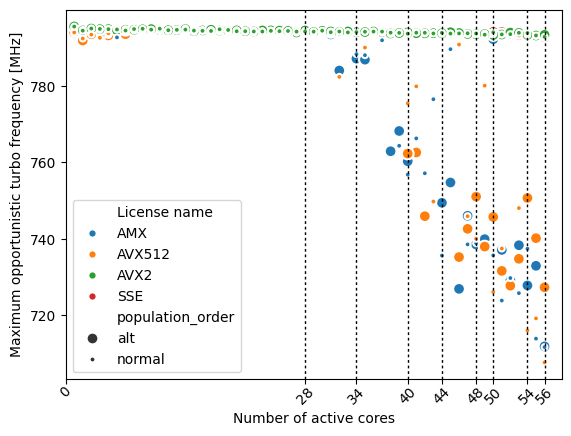

In [32]:
ax = sns.scatterplot(data=data[data['metric'] == 'perf-freq'], x=CORE_COUNT, y=MAX_TURBO_FREQ, hue=LIC_NAME, size='population_order', linewidth=1.5, marker='o', hue_order=hue_order)
plt.xticks(rotation=45)

buckets = [28,34,40,44,48,50,54,56]

for i in buckets:
    plt.axvline(x=i, color='black', dashes=[2], linewidth=1)

# ax.set_ylim(0, 4000)
ax.set_xlim(0, 58)
ax.set_xticks([0] + buckets)

# plt.xticks(rotation=45)
ax.tick_params(axis='x', pad=0)

# plt.savefig('../../thesis/fig/validate-avx-frequency-license-bands.pdf', bbox_inches='tight')